### Sensors

In [4]:
import os.path as op
import numpy as np
import pandas as pd
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from mne.beamformer import make_lcmv, apply_lcmv_epochs
from base import ensure_dir
from config import *
import gc
import os
import sys
import os

# params
subjects = SUBJS
subject = subjects[0]
lock = "stim"
trial_type = 'pattern'

data_path = DATA_DIR
subjects_dir = FREESURFER_DIR
folds = 10
solver = 'lbfgs'
scoring = "accuracy"

is_cluster = os.getenv("SLURM_ARRAY_TASK_ID") is not None
overwrite = False
verbose = True
jobs = -1

epoch_num = 1

In [5]:
# set-up the classifier and cv structure
clf = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=100000, solver=solver, class_weight="balanced", random_state=42, n_jobs=jobs))
# clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=100000, solver=solver, class_weight="balanced", random_state=42, n_jobs=-1))
clf = SlidingEstimator(clf, scoring=scoring, n_jobs=jobs, verbose=verbose)
cv = StratifiedKFold(folds, shuffle=True, random_state=42)

In [6]:
# read behav
behav = pd.read_pickle(op.join(data_path, 'behav', f'{subject}-{epoch_num}.pkl'))
# read epoch
epoch_fname = op.join(data_path, lock, f"{subject}-{epoch_num}-epo.fif")
epoch = mne.read_epochs(epoch_fname, verbose=verbose, preload=True)

if trial_type == 'pattern':
    pattern = behav.trialtypes == 1
    X = epoch.get_data()[pattern]
    y = behav.positions[pattern]
elif trial_type == 'random':
    random = behav.trialtypes == 2
    X = epoch.get_data()[random]
    y = behav.positions[random]
else:
    X = epoch.get_data()
    y = behav.positions
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]

sensor_scores = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)


Reading /Users/coum/Desktop/asrt/preprocessed/stim/sub01-1-epo.fif ...
    Found the data of interest:
        t =    -196.61 ...     599.65 ms
        0 CTF compensation matrices available
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated


/var/folders/0x/4l778zdn0l524g42s5_nc48h0000gn/T/ipykernel_73381/3231275819.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epoch.get_data()[pattern]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.6s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


In [12]:
from sklearn.decomposition import PCA
from mne.decoding import UnsupervisedSpatialFilter

pca = UnsupervisedSpatialFilter(PCA(1000), average=False)
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="empirical", rank="info", verbose=verbose)
noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="empirical", rank="info", verbose=verbose)
# conpute rank
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
# read forward solution
fwd_fname = RESULTS_DIR / "fwd" / lock / f"{subject}-{epoch_num}-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank=rank, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
data = np.array([np.real(stc.data) for stc in stcs])
stcs_data = pca.fit_transform(data)

if trial_type == 'pattern':
    pattern = behav.trialtypes == 1
    X = stcs_data[pattern]
    y = behav.positions[pattern]
elif trial_type == 'random':
    random = behav.trialtypes == 2
    X = stcs_data[random]
    y = behav.positions[random]
else:
    X = stcs_data
    y = behav.positions    
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]
source_sc = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)


Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 18228
[done]
Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 6174
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.4e-13 (2.2e-16 eps * 246 dim * 2.6  max singular value)
    Estimated rank (mag): 242
    MAG: rank 242 computed from 246 data channels with 0 projectors
Reading forward solution from /Users/coum/Desktop/asrt/results/fwd/stim/sub01-1-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 246 channels, free orientations)
    Source spaces 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished


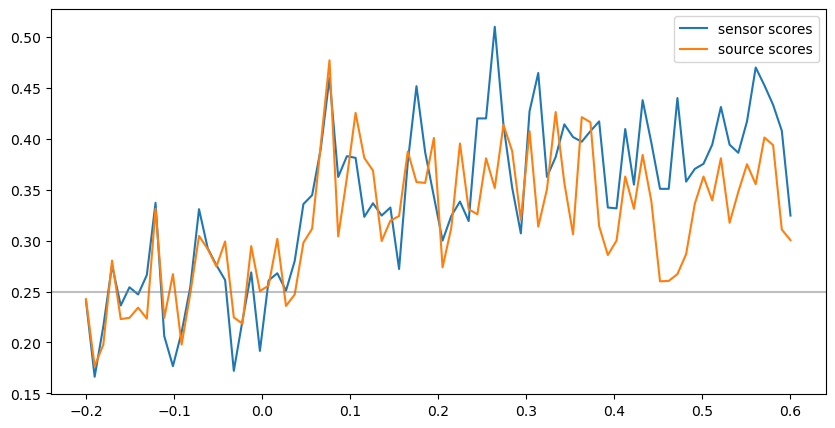

In [13]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(times, sensor_scores.mean(0), label='sensor scores')
ax.plot(times, source_sc.mean(0), label='source scores')
# ax.plot(times, source_sc1.mean(0), label='relative source scores')
# ax.plot(times, noise_sc.mean(0), label='data_reduced')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()